In [45]:
# 52-Week LTV Forecast

# Objective
#Predict full-year cumulative LTV based on 32 observed weeks.



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Завантажуємо наш файл
df = pd.read_csv("data/LTV.csv", sep=";")

# Переглядаємо наш дата сет
df.head()

,user_id,event_timestamp,first_purchase_time,cohort_week,lifetime_weeks,product_id
0,6f8592c0-fb4c-47dc-9344-424eb5d88a4b,2023-10-13 9:54:02,2023-10-13 9:54:02,2023-10-08,0.0,weekly.2.49
1,95287b91-85af-4174-9986-aeafb3853bb6,2023-10-14 4:45:14,2023-03-25 4:44:40,2023-03-19,29.0,weekly.2.49
2,95287b91-85af-4174-9986-aeafb3853bb6,2023-03-25 4:44:40,2023-03-25 4:44:40,2023-03-19,0.0,weekly.2.49
3,95287b91-85af-4174-9986-aeafb3853bb6,2023-04-01 4:44:16,2023-03-25 4:44:40,2023-03-19,1.0,weekly.2.49
4,95287b91-85af-4174-9986-aeafb3853bb6,2023-04-08 4:45:55,2023-03-25 4:44:40,2023-03-19,2.0,weekly.2.49


In [46]:
# Перетворюємо дату
df["event_timestamp"] = pd.to_datetime(df["event_timestamp"])
df["first_purchase_time"] = pd.to_datetime(df["first_purchase_time"])
df["cohort_week"] = pd.to_datetime(df["cohort_week"])

# Витягуємо ціну з product_id
df["price"] = df["product_id"].str.extract(r'(\d+\.\d+)').astype(float)

In [47]:
# Розмір когорт

cohort_sizes = (
    df.groupby("cohort_week")["user_id"]
    .nunique()
    .reset_index()
    .rename(columns={"user_id": "cohort_size"})
)

In [48]:
# Revenue по когорті та тижнях життя

cohort_revenue = (
    df.groupby(["cohort_week", "lifetime_weeks"])["price"]
    .sum()
    .reset_index()
)

In [49]:
# Cumulative revenue

cohort_revenue["cumulative_revenue"] = (
    cohort_revenue
    .sort_values(["cohort_week", "lifetime_weeks"])
    .groupby("cohort_week")["price"]
    .cumsum()
)

In [50]:
# Додаємо розмір когорт

cohort_ltv = cohort_revenue.merge(cohort_sizes, on="cohort_week")

cohort_ltv["ltv_per_user"] = (
    cohort_ltv["cumulative_revenue"] / cohort_ltv["cohort_size"]
)

In [51]:
# Агрегуємо середній LTV по всіх когорт

avg_ltv = (
    cohort_ltv
    .groupby("lifetime_weeks")
    .apply(lambda x: np.average(x["ltv_per_user"], weights=x["cohort_size"]))
    .reset_index(name="ltv_per_user")
)


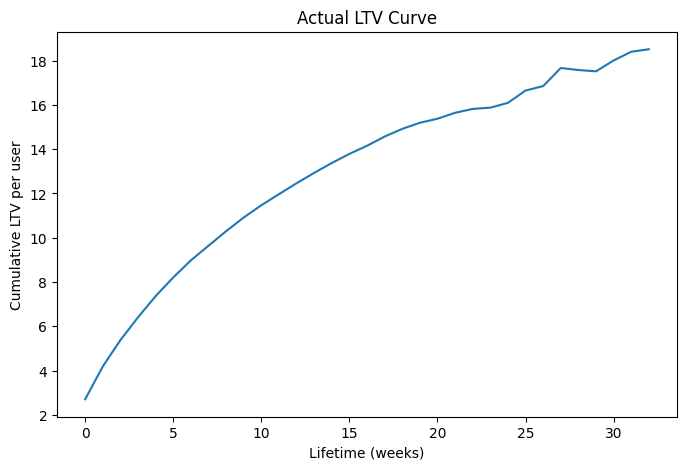

In [52]:
# Будуємо фактичну криву

plt.figure(figsize=(8,5))
plt.plot(avg_ltv["lifetime_weeks"], avg_ltv["ltv_per_user"])
plt.xlabel("Lifetime (weeks)")
plt.ylabel("Cumulative LTV per user")
plt.title("Actual LTV Curve")
plt.savefig("Actual LTV Curve.png", dpi=200)
plt.show()

In [53]:
# КОД ПІДГОНКИ МОДЕЛІ
# Дані
x = avg_ltv["lifetime_weeks"].values
y = avg_ltv["ltv_per_user"].values

# Модель
def ltv_model(t, a, b):
    return a * (1 - np.exp(-b * t))

# Підгонка
params, covariance = curve_fit(
    ltv_model,
    x,
    y,
    bounds=(0, np.inf),   # a > 0, b > 0
    maxfev=10000
)

a, b = params

print("Estimated a (plateau):", a)
print("Estimated b (growth rate):", b)


Estimated a (plateau): 17.982480676123583
Estimated b (growth rate): 0.10684829723078912


In [54]:
# СТВОРЮЄМО ПРЕДИКТ ДО 52 ТИЖНІВ

future_weeks = np.arange(0, 53)

predicted_ltv = ltv_model(future_weeks, a, b)

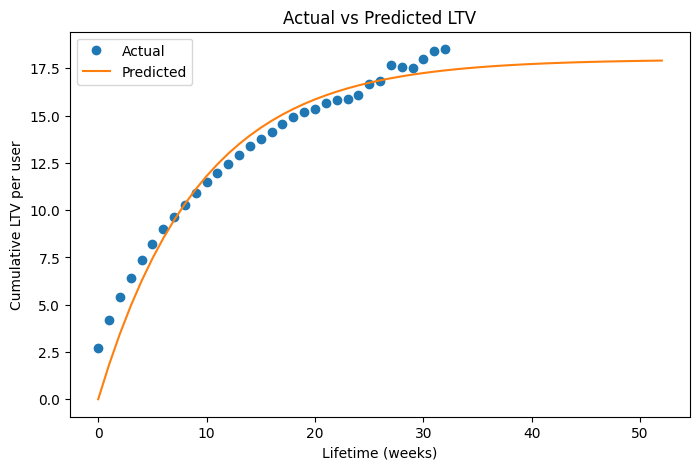

In [55]:
# ВІЗУАЛІЗАЦІЯ ФАКТ vs PREDICT

plt.figure(figsize=(8,5))

plt.plot(x, y, 'o', label="Actual")
plt.plot(future_weeks, predicted_ltv, label="Predicted")
plt.legend()


plt.xlabel("Lifetime (weeks)")
plt.ylabel("Cumulative LTV per user")
plt.title("Actual vs Predicted LTV")
plt.savefig("Actual vs Predicted LTV.png", dpi=200)
plt.show()


In [56]:
# Показуєм який Predicted LTV at 52 weeks

predicted_ltv_52 = ltv_model(52, a, b)
print("Predicted LTV at 52 weeks:", predicted_ltv_52)


Predicted LTV at 52 weeks: 17.91300047673143


In [57]:
# Прогноз для існуючих точок
y_pred_existing = ltv_model(x, a, b)

# Обчислюємо SS_res (залишкова сума квадратів)
ss_res = np.sum((y - y_pred_existing) ** 2)

# Обчислюємо SS_tot (загальна варіація)
ss_tot = np.sum((y - np.mean(y)) ** 2)

# R² вручну
r2 = 1 - (ss_res / ss_tot)

print("R-squared:", r2)



R-squared: 0.9532049105731754


In [58]:
# LTV краще описується логарифмом: LTV(t)=a⋅log(1+bt)

def log_model(t, a, b):
    return a * np.log(1 + b * t)

params_log, _ = curve_fit(log_model, x, y, maxfev=10000)

a_log, b_log = params_log

# прогноз
future_weeks = np.arange(0, 53)
pred_log = log_model(future_weeks, a_log, b_log)

# R²
y_pred_log = log_model(x, a_log, b_log)

ss_res_log = np.sum((y - y_pred_log) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)

r2_log = 1 - (ss_res_log / ss_tot)

print("Log model R²:", r2_log)
print("Log predicted LTV 52:", log_model(52, a_log, b_log))


Log model R²: 0.9814730960007294
Log predicted LTV 52: 20.922986847390764


C:\Users\wital\AppData\Local\Temp\ipykernel_16196\3293784815.py:4: RuntimeWarning: invalid value encountered in log
  return a * np.log(1 + b * t)


In [59]:
# беремо перші 24 тижні
# будуємо модель
# перевіряємо на 25–32

# train = до 24 тижнів
train_mask = x <= 24

x_train = x[train_mask]
y_train = y[train_mask]

params_train, _ = curve_fit(ltv_model, x_train, y_train, maxfev=10000)

a_train, b_train = params_train

# прогноз на весь горизонт
y_pred_full = ltv_model(x, a_train, b_train)

# R² на тест частині
test_mask = x > 24

ss_res_test = np.sum((y[test_mask] - y_pred_full[test_mask]) ** 2)
ss_tot_test = np.sum((y[test_mask] - np.mean(y[test_mask])) ** 2)

r2_test = 1 - (ss_res_test / ss_tot_test)

print("Out-of-sample R²:", r2_test)


Out-of-sample R²: -7.880914567313514


In [60]:
# MAPE

mape = np.mean(np.abs((y - y_pred_existing) / y)) * 100
print("MAPE (%):", mape)


MAPE (%): 9.903021160110885


In [61]:
# Bootstrap довірчий інтервал

n_boot = 1000
ltv_52_boot = []

for i in range(n_boot):

    # випадковий вибір з заміною
    indices = np.random.choice(len(x), len(x), replace=True)

    x_sample = x[indices]
    y_sample = y[indices]

    try:
        params_boot, _ = curve_fit(ltv_model, x_sample, y_sample, maxfev=10000)
        a_boot, b_boot = params_boot

        ltv_52 = ltv_model(52, a_boot, b_boot)
        ltv_52_boot.append(ltv_52)

    except:
        continue

ltv_52_boot = np.array(ltv_52_boot)

print("Mean LTV(52):", np.mean(ltv_52_boot))
print("95% CI:", np.percentile(ltv_52_boot, [2.5, 97.5]))


C:\Users\wital\AppData\Local\Temp\ipykernel_16196\975006275.py:8: RuntimeWarning: overflow encountered in exp
  return a * (1 - np.exp(-b * t))
C:\Users\wital\AppData\Local\Temp\ipykernel_16196\75139985.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  params_boot, _ = curve_fit(ltv_model, x_sample, y_sample, maxfev=10000)
C:\Users\wital\AppData\Local\Temp\ipykernel_16196\975006275.py:8: RuntimeWarning: overflow encountered in multiply
  return a * (1 - np.exp(-b * t))


Mean LTV(52): 17.65417255832937
95% CI: [14.01111165 18.53480545]


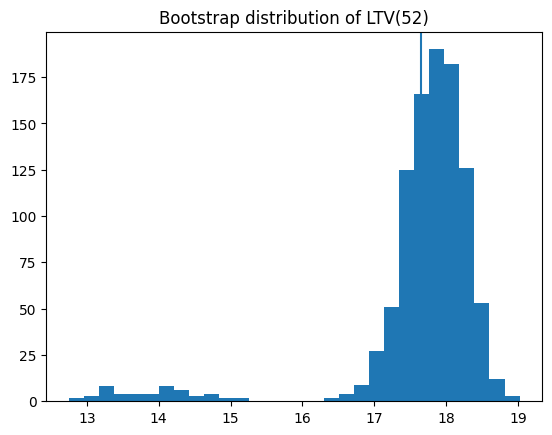

In [62]:
# Побудова розподілу

plt.hist(ltv_52_boot, bins=30)
plt.axvline(np.mean(ltv_52_boot))
plt.title("Bootstrap distribution of LTV(52)")
plt.savefig("Bootstrap distribution of LTV(52)", dpi=200)
plt.show()


In [63]:
# Тепер робимо 3 сценарії:
# Conservative = 5 percentile
# Base = mean
# Optimistic = 95 percentile

conservative = np.percentile(ltv_52_boot, 5)
base = np.mean(ltv_52_boot)
optimistic = np.percentile(ltv_52_boot, 95)

print("Conservative:", conservative)
print("Base:", base)
print("Optimistic:", optimistic)

Conservative: 16.331715279412524
Base: 17.65417255832937
Optimistic: 18.456435984795352


In [64]:
# Якщо у нас 100 000 нових юзерів:
# Revenue forecast:

users = 100000

print("Revenue conservative:", conservative * users)
print("Revenue base:", base * users)
print("Revenue optimistic:", optimistic * users)


Revenue conservative: 1633171.5279412523
Revenue base: 1765417.255832937
Revenue optimistic: 1845643.5984795352


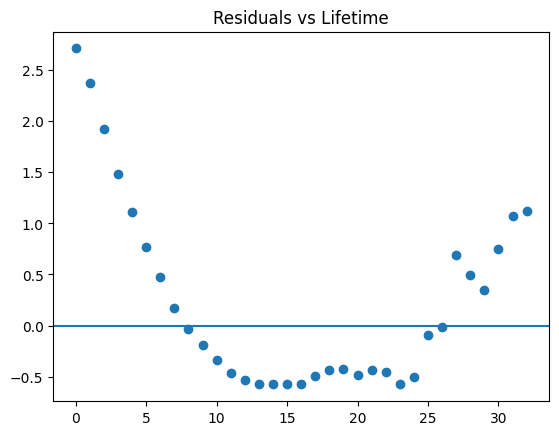

In [65]:
# Діагностика моделі
# Тепер важливо перевірити залишки (residuals).

residuals = y - ltv_model(x, a, b)

plt.scatter(x, residuals)
plt.axhline(0)
plt.title("Residuals vs Lifetime")
plt.savefig("Residuals vs Lifetime", dpi=200)
plt.show()